In [70]:
# ✅ Imports + Fixed Output Paths
import os
import re
import pandas as pd
from collections import Counter
import networkx as nx
from pathlib import Path

# Set fixed root (adjust if notebook location ever changes)
PROJECT_ROOT = Path(__file__).resolve().parents[1] if "__file__" in globals() else Path.cwd().parents[1]

TRANSCRIPTION_PATH = PROJECT_ROOT / "outputs" / "transcriptions" / "kurmanci_transcription_comparison.csv"
FREQ_OUT_DIR = PROJECT_ROOT / "outputs" / "frequencies" / "kurmanci"
GRAPH_OUT_DIR = PROJECT_ROOT / "outputs" / "visualizations"

FREQ_OUT_DIR.mkdir(parents=True, exist_ok=True)
GRAPH_OUT_DIR.mkdir(parents=True, exist_ok=True)


In [71]:
# ✅ Load Data
df = pd.read_csv(TRANSCRIPTION_PATH)
print(f"✅ Loaded {len(df)} rows from:\n{TRANSCRIPTION_PATH}")


✅ Loaded 3973 rows from:
c:\Users\berfi\Documents\GitHub\dialectalwordmining\outputs\transcriptions\kurmanci_transcription_comparison.csv


In [72]:
# ✅ Cell 3: Stopwords + Tokenizer
kurmanci_stopwords = {
    "ji", "li", "bi", "di", "ê", "în", "he", "ye", "ne", "ku", "û", "le", "da", "e", "ev", "ew",
    "ez", "tu", "min", "te", "me", "wî", "wê", "hûn", "em", "jî", "re", "ya", "bo", "ser", "bû",
    "te", "in", "heye", "ya", "dibe", "dest", "pir", "ve", "her"
}


def normalize_text(text):
    if not isinstance(text, str): return ""
    text = text.lower()
    text = re.sub(r"[^\w\sçğıöşüêîû]", "", text)
    return re.sub(r"\s+", " ", text).strip()

def tokenize(text):
    tokens = normalize_text(text).split()
    return [
        tok for tok in tokens
        if tok not in kurmanci_stopwords and tok.isalpha() and len(tok) > 1
    ]


In [73]:
# ✅ Cell 4: Filter usable records
df_clean = df[df["ground_truth"].notna() & ~df["whisper_pred"].str.startswith("[ERROR]")].copy()


In [74]:
# ✅ Cell 5: Count Words
def get_word_counts(column):
    tokens = []
    for sentence in column:
        tokens.extend(tokenize(sentence))
    return Counter(tokens)

gt_counts = get_word_counts(df_clean["ground_truth"])
whisper_counts = get_word_counts(df_clean["whisper_pred"])
w2v2_counts = get_word_counts(df_clean["w2v2_pred"]) if "w2v2_pred" in df.columns else None


In [75]:
# ✅ Cell 6: Co-occurrence Graph
G = nx.Graph()
for sent in df_clean["ground_truth"]:
    words = tokenize(sent)
    for i in range(len(words)):
        for j in range(i+1, min(i+3, len(words))):  # bi/tri-gram window
            if words[i] != words[j]:
                G.add_edge(words[i], words[j], weight=G.get_edge_data(words[i], words[j], {"weight": 0})["weight"] + 1)


In [76]:
# ✅ Save outputs
pd.DataFrame(gt_counts.most_common()).to_csv(FREQ_OUT_DIR / "gt_word_freq.csv", index=False)
pd.DataFrame(whisper_counts.most_common()).to_csv(FREQ_OUT_DIR / "whisper_word_freq.csv", index=False)
if w2v2_counts:
    pd.DataFrame(w2v2_counts.most_common()).to_csv(FREQ_OUT_DIR / "w2v2_word_freq.csv", index=False)

nx.write_gexf(G, GRAPH_OUT_DIR / "kurmanci_gt_word_cooccurrence.gexf")
print("✅ Word counts and co-occurrence graph saved to:")
print(FREQ_OUT_DIR)
print(GRAPH_OUT_DIR)

✅ Word counts and co-occurrence graph saved to:
c:\Users\berfi\Documents\GitHub\dialectalwordmining\outputs\frequencies\kurmanci
c:\Users\berfi\Documents\GitHub\dialectalwordmining\outputs\visualizations


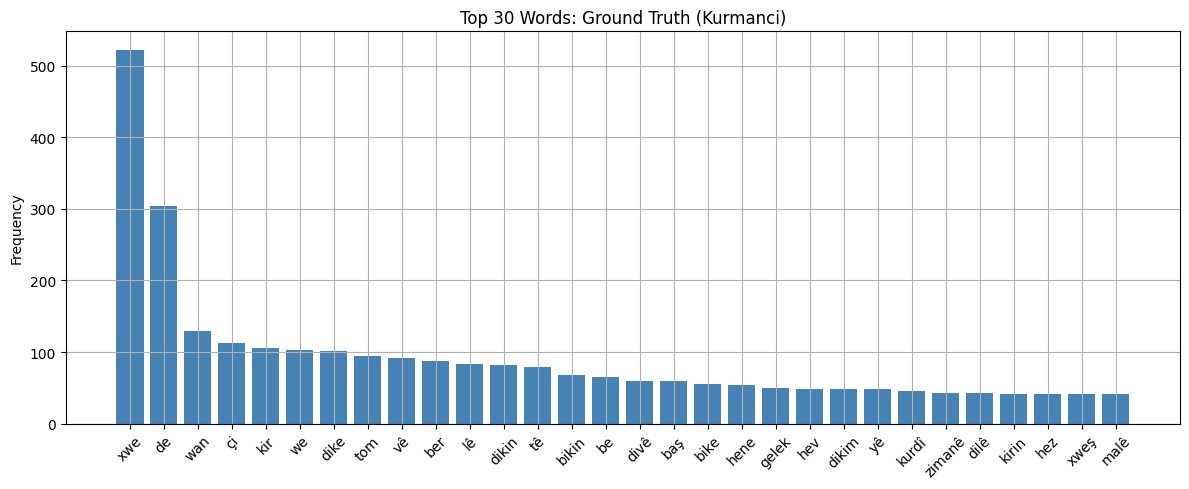

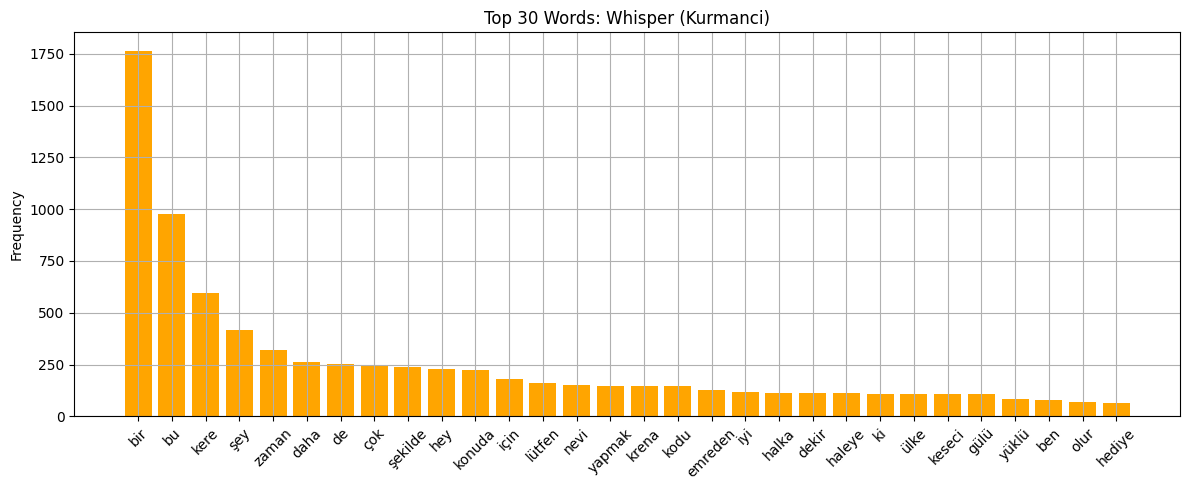

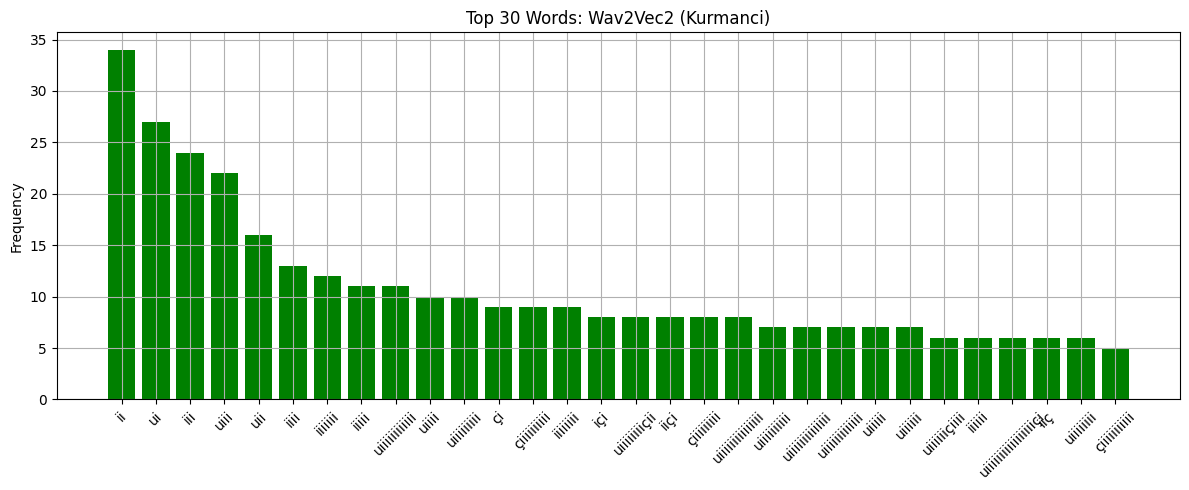

In [77]:
# ✅ Cell 8: Top-30 Bar Plots (NEW — after Cell 7)
import matplotlib.pyplot as plt

def plot_top_words(counter, title, color):
    top_words = counter.most_common(30)
    words, freqs = zip(*top_words)
    plt.figure(figsize=(12, 5))
    plt.bar(words, freqs, color=color)
    plt.xticks(rotation=45)
    plt.title(f"Top 30 Words: {title}")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_top_words(gt_counts, "Ground Truth (Kurmanci)", "steelblue")
plot_top_words(whisper_counts, "Whisper (Kurmanci)", "orange")
if w2v2_counts:
    plot_top_words(w2v2_counts, "Wav2Vec2 (Kurmanci)", "green")


In [78]:
# 🔍 Extra Analysis: Compare top-30 words before and after stopword removal
def get_counts_without_stopwords(texts):
    tokens = []
    for t in texts:
        tokens.extend(normalize_text(t).split())  # no stopword filtering
    return Counter(tokens)

gt_counts_no_filter = get_counts_without_stopwords(df_clean["ground_truth"])

# Compare top 30 words
top_with_stopwords = [w for w, _ in gt_counts_no_filter.most_common(30)]
top_without_stopwords = [w for w, _ in gt_counts.most_common(30)]

print("🆚 Top words before stopword removal:", top_with_stopwords)
print("✅ Top words after stopword removal:", top_without_stopwords)

overlap = len(set(top_with_stopwords) & set(top_without_stopwords)) / len(top_with_stopwords)
print(f"🔁 Overlap (with vs without stopwords): {overlap:.2f}")


🆚 Top words before stopword removal: ['ji', 'li', 'bi', 'xwe', 'û', 'min', 'ez', 'e', 'de', 'di', 'ew', 'em', 'ku', 'me', 'ye', 'ê', 'jî', 'tu', 'te', 're', 'ne', 'wê', 'wî', 'ev', 'wan', 'çi', 'bo', 'ser', 'bû', 'hûn']
✅ Top words after stopword removal: ['xwe', 'de', 'wan', 'çi', 'kir', 'we', 'dike', 'tom', 'vê', 'ber', 'lê', 'dikin', 'tê', 'bikin', 'be', 'divê', 'baş', 'bike', 'hene', 'gelek', 'hev', 'dikim', 'yê', 'kurdî', 'zimanê', 'dilê', 'kirin', 'hez', 'xweş', 'malê']
🔁 Overlap (with vs without stopwords): 0.13
